# Solving MaxCut on a weighted graph with QVM

In [217]:
#Maxcut by QAOA
import numpy as np
import pyquil.api as api
from pyquil.paulis import PauliTerm, PauliSum
import networkx as nx
from scipy.optimize import minimize
from grove.pyqaoa.qaoa import QAOA
qvm_connection = api.QVMConnection()


def print_fun(x):
    print(x)


def maxcut_qaoa(graph, weight, steps=2, rand_seed=None, connection=None, samples=None,
                initial_beta=None, initial_gamma=None, minimizer_kwargs=None,
                vqe_option=None):
    
    if not isinstance(graph, nx.Graph) and isinstance(graph, list):
        maxcut_graph = nx.Graph()
        for edge in graph:
            maxcut_graph.add_edge(*edge)
        graph = maxcut_graph.copy()

    cost_operators = []
    driver_operators = []
    for i, j in graph.edges():
        cost_operators.append(PauliTerm("Z", i, 0.5*(weight[i][j]))*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
    for i in graph.nodes():
        driver_operators.append(PauliSum([PauliTerm("X", i, -1.0)]))

    if connection is None:
        connection = qvm_connection

    if minimizer_kwargs is None:
        minimizer_kwargs = {'method': 'Nelder-Mead',
                            'options': {'ftol': 1.0e-2, 'xtol': 1.0e-2,
                                        'disp': False}}
    if vqe_option is None:
        vqe_option = {'disp': print_fun, 'return_all': True,
                      'samples': samples}

    qaoa_inst = QAOA(connection, list(graph.nodes()), steps=steps, cost_ham=cost_operators,
                     ref_ham=driver_operators, store_basis=True,
                     rand_seed=rand_seed,
                     init_betas=initial_beta,
                     init_gammas=initial_gamma,
                     minimizer=minimize,
                     minimizer_kwargs=minimizer_kwargs,
                     vqe_options=vqe_option)

    return qaoa_inst

## Example-1

In [273]:
import random

# importing networkx 
import networkx as nx 
# importing matplotlib.pyplot 
import matplotlib.pyplot as plt

#Generate a random adjacency matrix for a weighted graph
def random_adjacency_matrix(n):
    import numpy as np

    weight = [[random.randint(0, 2) for i in range(n)] for j in range(n)]

    # No vertex connects to itself
    for i in range(n):
        weight[i][i] = 0

    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            weight[j][i] = weight[i][j]
            
    print(np.matrix(weight))
    
    A = weight
    G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
    layout = nx.spring_layout(G)
    nx.draw(G, layout,  with_labels = True, node_color=['green'], node_size=1200, alpha=1)
    nx.draw_networkx_edge_labels(G, pos=layout, font_color='black', font_weight='bold')
    #nx.draw_networkx_edges(G, pos=layout, arrows=False, label='w')
    plt.show()
    return weight

[[0 1 2 2]
 [1 0 2 0]
 [2 2 0 1]
 [2 0 1 0]]


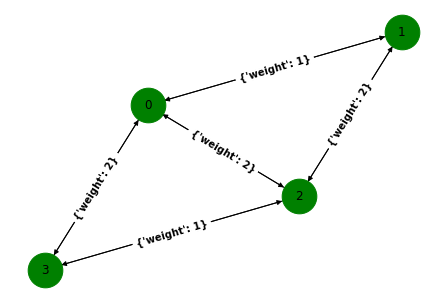

                     models will be ineffective
	Parameters: [0.74341461 1.39845321 1.66538463 2.5835973 ] 
	E => -5.555671755400308
	Parameters: [0.74341461 1.39845321 1.66538463 2.5835973 ] 
	E => -4.995376930766383
	Parameters: [0.78120112 1.39359747 1.6371684  2.37251273] 
	E => -6.377117053998175
	Parameters: [0.78120112 1.39359747 1.6371684  2.37251273] 
	E => -6.339294461440377
	Parameters: [0.8216117  1.29344782 1.7374144  2.33007695] 
	E => -7.052968728396687
	Parameters: [0.81673094 1.1723578  1.73604277 2.41233427] 
	E => -7.54419802332616
	Parameters: [0.81673094 1.1723578  1.73604277 2.41233427] 
	E => -6.991696305222257
	Parameters: [0.81673094 1.1723578  1.73604277 2.41233427] 
	E => -7.2579778190608675
	Parameters: [0.85553086 1.13134718 1.78569642 2.37860328] 
	E => -8.312591001832688
	Parameters: [0.80706014 1.16918485 1.79931459 2.5281814 ] 
	E => -8.781017616583068
	Parameters: [0.80706014 1.16918485 1.79931459 2.5281814 ] 
	E => -8.207430287542842
	Parameters: [0.8

In [280]:
inst = maxcut_qaoa(G, random_adjacency_matrix(4), steps=2, rand_seed=50, samples=None)
betas, gammas = inst.get_angles()


In [289]:
print('beta=',betas, 'gamma=',gammas)

beta= [0.96916851 1.21338792] gamma= [1.85476356 2.47064921]


In [281]:
state_v=[]
prob_v=[]
probs = inst.probabilities(np.hstack((betas, gammas)))

for state, prob in zip(inst.states, probs):
    state_v.append(state)
    prob_v.append(prob)
    print(state, prob)

print("Most frequent bitstring from sampling")
most_freq_string, sampling_results = inst.get_string(betas, gammas)
print(most_freq_string)

0000 [0.00279614+0.j]
0001 [0.00196019+0.j]
0010 [0.00196019+0.j]
0011 [0.06697823+0.j]
0100 [0.00196019+0.j]
0101 [0.40198964+0.j]
0110 [0.02039523+0.j]
0111 [0.00196019+0.j]
1000 [0.00196019+0.j]
1001 [0.02039523+0.j]
1010 [0.40198964+0.j]
1011 [0.00196019+0.j]
1100 [0.06697823+0.j]
1101 [0.00196019+0.j]
1110 [0.00196019+0.j]
1111 [0.00279614+0.j]
Most frequent bitstring from sampling
(1, 0, 1, 0)


In [288]:
new1=np.concatenate( probs, axis=0 )
from array import *
new2=new1.tolist()

<BarContainer object of 16 artists>

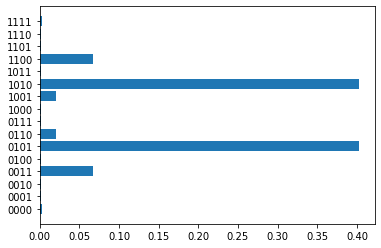

In [287]:
plt.barh(state_v,new2) 

In [294]:
angles = np.hstack((betas, gammas))
param_prog = inst.get_parameterized_program()
prog = param_prog(angles)
print(prog)
print("Number of gates:", len(prog))

H 0
H 1
H 2
H 3
CNOT 0 1
RZ(1.854763555864237) 1
CNOT 0 1
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 0 3
RZ(3.709527111728474) 3
CNOT 0 3
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 1 0
RZ(1.854763555864237) 0
CNOT 1 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 1 2
RZ(3.709527111728474) 2
CNOT 1 2
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 2 1
RZ(3.709527111728474) 1
CNOT 2 1
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 2 3
RZ(1.854763555864237) 3
CNOT 2 3
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 3 0
RZ(3.709527111728474) 0
CNOT 3 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
CNOT 3 2
RZ(1.854763555864237) 2
CNOT 3 2
X 0
PHASE(0.9273817779321185) 0
X 0
PHASE(0.9273817779321185) 0
H 0
RZ(-

In [295]:
qubits = [0, 1, 2, 3]

measurements = qvm_connection.run_and_measure(prog, qubits, trials=1000)


In [296]:
from collections import Counter
# This is just a hack - we can't use Counter on a list of lists but we can on a list of tuples.
measurements = [tuple(measurement) for measurement in measurements]
measurements_counter = Counter(measurements)
# This line gives us the results in the decreasing order
measurements_counter.most_common()

[((1, 0, 1, 0), 417),
 ((0, 1, 0, 1), 381),
 ((0, 0, 1, 1), 77),
 ((1, 1, 0, 0), 67),
 ((0, 1, 1, 0), 19),
 ((1, 0, 0, 1), 16),
 ((0, 0, 0, 0), 6),
 ((0, 0, 1, 0), 5),
 ((1, 0, 1, 1), 3),
 ((0, 0, 0, 1), 3),
 ((1, 1, 1, 0), 2),
 ((1, 0, 0, 0), 1),
 ((1, 1, 1, 1), 1),
 ((0, 1, 1, 1), 1),
 ((1, 1, 0, 1), 1)]

In [297]:
wf = qvm_connection.wavefunction(prog)
print(wf)

(-0.0154137142+0.0505821613j)|0000> + (-0.0227179159-0.0380011595j)|0001> + (-0.0227179159-0.0380011595j)|0010> + (0.1532225732-0.2085691026j)|0011> + (-0.0227179159-0.0380011595j)|0100> + (-0.4730605959-0.4221413434j)|0101> + (-0.1347782538-0.0472233911j)|0110> + (-0.0227179159-0.0380011595j)|0111> + (-0.0227179159-0.0380011595j)|1000> + (-0.1347782538-0.0472233911j)|1001> + (-0.4730605959-0.4221413434j)|1010> + (-0.0227179159-0.0380011595j)|1011> + (0.1532225732-0.2085691026j)|1100> + (-0.0227179159-0.0380011595j)|1101> + (-0.0227179159-0.0380011595j)|1110> + (-0.0154137142+0.0505821613j)|1111>


In [300]:
print("Probability amplitudes for all the possible states:")
for state_index in range(inst.nstates):
    print(inst.states[state_index], wf[state_index])

Probability amplitudes for all the possible states:
0000 (-0.015413714158862911+0.05058216128099329j)
0001 (-0.02271791591970658-0.03800115947991067j)
0010 (-0.022717915919706733-0.038001159479910784j)
0011 (0.15322257319650132-0.20856910262602069j)
0100 (-0.022717915919706705-0.03800115947991076j)
0101 (-0.4730605958734503-0.42214134344506893j)
0110 (-0.13477825375268992-0.04722339111290287j)
0111 (-0.02271791591970662-0.038001159479910944j)
1000 (-0.02271791591970662-0.038001159479910944j)
1001 (-0.13477825375268992-0.04722339111290287j)
1010 (-0.4730605958734503-0.42214134344506893j)
1011 (-0.022717915919706705-0.03800115947991076j)
1100 (0.15322257319650132-0.20856910262602069j)
1101 (-0.022717915919706733-0.038001159479910784j)
1110 (-0.02271791591970658-0.03800115947991067j)
1111 (-0.015413714158862911+0.05058216128099329j)


In [303]:
print("Probabilities of measuring given states:")
states_with_probs = []
for state_index in range(inst.nstates):
    states_with_probs.append([inst.states[state_index], np.real(np.conj(wf[state_index])*wf[state_index])])
    print(states_with_probs[-1][0], states_with_probs[-1][1])

Probabilities of measuring given states:
0000 0.0027961376240275477
0001 0.0019601918255524623
0010 0.001960191825552478
0011 0.06697822750718076
0100 0.0019601918255524745
0101 0.40198964121375147
0110 0.02039522635282667
0111 0.001960191825552485
1000 0.001960191825552485
1001 0.02039522635282667
1010 0.40198964121375147
1011 0.0019601918255524745
1100 0.06697822750718076
1101 0.001960191825552478
1110 0.0019601918255524623
1111 0.0027961376240275477


In [304]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_state_histogram(states_with_probs):
    states = np.array(states_with_probs)[:,0]
    probs = np.array(states_with_probs)[:,1].astype(float)
    n = len(states_with_probs)
    plt.barh(range(n), probs, tick_label=states)
    plt.show()

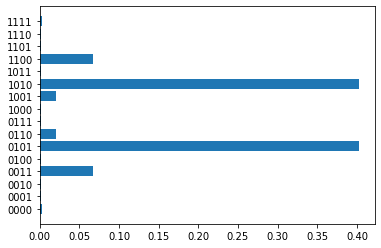

In [305]:
plot_state_histogram(states_with_probs)